# NMTLR

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

#from pycox.datasets import metabric
from pycox.models import MTLR
from pycox.evaluation import EvalSurv
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from pycox.models.utils import pad_col

In [2]:
def analyze_file(data):
    print("Dataset:")
    display(data)
    
    # Output the shape of the dataset
    print("\nShape of the dataset (rows, columns):")
    print(data.shape)
    
    # Output the data types of each column
    print("\nData types of each column:")
    print(data.dtypes)
    
    # Output the count of missing values in each column
    print("\nCount of missing values in each column:")
    print(data.isnull().sum())
def get_high_correlation_features(df, target_columns, threshold=0.9):
    """
    Get features with correlation greater than the specified threshold with the target variables.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with features and target variables.
    - target_columns (list of str): List of target variable column names.
    - threshold (float): Correlation threshold to filter features.

    Returns:
    - dict: A dictionary where keys are column names and values are their correlation values.
    """
    high_corr_features = {}

    # Compute correlation matrix
    corr_matrix = df.corr()

    # Iterate over columns in the DataFrame
    for column in df.columns:
        if column not in target_columns:
            # Check correlation with each target variable
            for target in target_columns:
                correlation_value = corr_matrix.loc[column, target]
                if abs(correlation_value) > threshold:
                    high_corr_features[column] = correlation_value
                    break  # No need to check other targets for this feature

    return high_corr_features

In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

# Dataset

In [4]:
data = pd.read_csv('/Users/simrantanwar/Desktop/College/DDP/survival_analysis/data/genomics_brain_16_09_24.csv')
analyze_file(data)

Dataset:


,Unnamed: 0,Patient ID,LASP1,HOXA11,CREBBP,ETV1,GAS7,CD79B,PAX7,BTK,...,CUX1,PIERCE2,SRGAP2,NCOA4,SSX4,TAF15,MLLT6,DUX4L1,OS,OS.time
0,0,TCGA-02-0047,8.923858,3.526361,8.244071,8.900549,9.184510,3.555348,2.302585,6.255750,...,8.282483,4.127134,8.053251,9.012621,0.0,8.319474,8.334952,0.0,1.0,448.0
1,1,TCGA-02-0055,8.460199,3.970292,7.816014,7.650645,7.964156,2.890372,1.609438,6.614726,...,8.368693,4.276666,7.794823,8.727130,0.0,8.235361,7.855157,0.0,1.0,76.0
2,2,TCGA-02-2483,9.164296,4.682131,8.572628,10.186973,8.340217,2.944439,1.609438,6.146329,...,8.606302,3.931826,8.222554,9.270965,0.0,8.883779,8.491260,0.0,0.0,466.0
3,3,TCGA-02-2485,9.133675,3.970292,8.474077,9.155250,6.938284,2.564949,1.791759,5.780744,...,8.629629,4.369448,8.235361,8.687779,0.0,9.019301,8.461046,0.0,0.0,470.0
4,4,TCGA-02-2486,8.626765,3.526361,7.090910,6.838405,8.690642,2.995732,0.693147,7.329750,...,8.512382,5.793014,7.963460,8.760139,0.0,8.525161,8.006034,0.0,1.0,618.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,8698,TCGA-WY-A85A,9.093245,1.791759,8.631414,10.231928,7.642524,0.693147,2.397895,5.602119,...,8.810460,3.891820,7.765993,8.910586,0.0,8.927977,9.006509,0.0,0.0,1320.0
661,8699,TCGA-WY-A85B,8.977778,2.397895,8.905037,10.492523,7.574558,2.484907,1.386294,6.572283,...,9.015906,4.234107,7.955074,9.328568,0.0,9.316770,9.229849,0.0,0.0,1393.0
662,8700,TCGA-WY-A85C,8.820552,6.282267,9.278466,9.983315,7.007601,1.945910,1.945910,5.730100,...,9.177714,3.610918,8.107720,9.145909,0.0,9.151757,9.219696,0.0,0.0,1426.0
663,8701,TCGA-WY-A85D,8.793612,0.000000,8.634443,8.751316,7.677400,2.197225,0.000000,5.983936,...,8.861208,3.637586,7.914983,8.731498,0.0,9.364005,8.856234,0.0,0.0,1147.0



Shape of the dataset (rows, columns):
(665, 752)

Data types of each column:
Unnamed: 0      int64
Patient ID     object
LASP1         float64
HOXA11        float64
CREBBP        float64
               ...   
TAF15         float64
MLLT6         float64
DUX4L1        float64
OS            float64
OS.time       float64
Length: 752, dtype: object

Count of missing values in each column:
Unnamed: 0    0
Patient ID    0
LASP1         0
HOXA11        0
CREBBP        0
             ..
TAF15         0
MLLT6         0
DUX4L1        0
OS            0
OS.time       0
Length: 752, dtype: int64


In [5]:
df = data.drop(columns=['Unnamed: 0','Patient ID'], axis=1)
analyze_file(df)

Dataset:


,LASP1,HOXA11,CREBBP,ETV1,GAS7,CD79B,PAX7,BTK,BRCA1,WAS,...,CUX1,PIERCE2,SRGAP2,NCOA4,SSX4,TAF15,MLLT6,DUX4L1,OS,OS.time
0,8.923858,3.526361,8.244071,8.900549,9.184510,3.555348,2.302585,6.255750,6.257668,7.026427,...,8.282483,4.127134,8.053251,9.012621,0.0,8.319474,8.334952,0.0,1.0,448.0
1,8.460199,3.970292,7.816014,7.650645,7.964156,2.890372,1.609438,6.614726,5.605802,7.315884,...,8.368693,4.276666,7.794823,8.727130,0.0,8.235361,7.855157,0.0,1.0,76.0
2,9.164296,4.682131,8.572628,10.186973,8.340217,2.944439,1.609438,6.146329,6.932448,6.867974,...,8.606302,3.931826,8.222554,9.270965,0.0,8.883779,8.491260,0.0,0.0,466.0
3,9.133675,3.970292,8.474077,9.155250,6.938284,2.564949,1.791759,5.780744,6.970730,6.242223,...,8.629629,4.369448,8.235361,8.687779,0.0,9.019301,8.461046,0.0,0.0,470.0
4,8.626765,3.526361,7.090910,6.838405,8.690642,2.995732,0.693147,7.329750,5.683580,7.600902,...,8.512382,5.793014,7.963460,8.760139,0.0,8.525161,8.006034,0.0,1.0,618.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,9.093245,1.791759,8.631414,10.231928,7.642524,0.693147,2.397895,5.602119,5.849325,6.272877,...,8.810460,3.891820,7.765993,8.910586,0.0,8.927977,9.006509,0.0,0.0,1320.0
661,8.977778,2.397895,8.905037,10.492523,7.574558,2.484907,1.386294,6.572283,6.376727,7.059618,...,9.015906,4.234107,7.955074,9.328568,0.0,9.316770,9.229849,0.0,0.0,1393.0
662,8.820552,6.282267,9.278466,9.983315,7.007601,1.945910,1.945910,5.730100,6.347389,6.428105,...,9.177714,3.610918,8.107720,9.145909,0.0,9.151757,9.219696,0.0,0.0,1426.0
663,8.793612,0.000000,8.634443,8.751316,7.677400,2.197225,0.000000,5.983936,5.796058,6.858565,...,8.861208,3.637586,7.914983,8.731498,0.0,9.364005,8.856234,0.0,0.0,1147.0



Shape of the dataset (rows, columns):
(665, 750)

Data types of each column:
LASP1      float64
HOXA11     float64
CREBBP     float64
ETV1       float64
GAS7       float64
            ...   
TAF15      float64
MLLT6      float64
DUX4L1     float64
OS         float64
OS.time    float64
Length: 750, dtype: object

Count of missing values in each column:
LASP1      0
HOXA11     0
CREBBP     0
ETV1       0
GAS7       0
          ..
TAF15      0
MLLT6      0
DUX4L1     0
OS         0
OS.time    0
Length: 750, dtype: int64


In [6]:
target_columns = ['OS','OS.time']
corr_value = get_high_correlation_features(df, target_columns, threshold=0.3)
#print(corr_value)
print(len(corr_value))
sorted_corr_value = dict(sorted(corr_value.items(), key=lambda item: item[1], reverse=True))


131


In [7]:
top_30_genes =list(sorted_corr_value.keys())[:30]

# Assuming 'target' and 'duration' are already identified from the column names
target_columns = ['OS','OS.time']

# Combine the top 20 genes and the additional columns
columns_to_select =  top_30_genes + target_columns

# Create a new DataFrame with these columns
top_30_genes_df = df[columns_to_select]

In [8]:
# Create a test set by sampling 20% of the training data
df_test = top_30_genes_df.sample(frac=0.2)

# Remove the test set from the original training data
df_train = top_30_genes_df.drop(df_test.index)

# Create a validation set by sampling 20% of the remaining training data
df_val = df_train.sample(frac=0.2)

# Remove the validation set from the remaining training data
df_train = df_train.drop(df_val.index)


In [9]:
analyze_file(df_train)

Dataset:


,HOXD11,MSN,IGF2BP2,TMSB4X,HOXC11,FKBP9,HOXC13,HOXD13,HMGA2,CDKN2C,...,MYD88,CASP8,COL1A1,FCGR2B,PDCD1LG2,BRIP1,RMI2,BUB1B,OS,OS.time
0,3.871201,10.236884,6.167516,11.127586,4.276666,8.697012,2.833213,5.703782,4.174387,7.558517,...,7.576610,5.849325,9.564302,6.104793,4.406719,5.659482,5.533389,6.008813,1.0,448.0
1,3.496508,10.350606,6.946976,11.797405,4.430817,9.072227,4.644391,5.075174,6.177944,7.784889,...,8.026497,6.484635,12.395159,8.279697,7.248504,5.214936,6.056784,5.905362,1.0,76.0
2,2.079442,9.214233,6.539586,11.569457,5.855072,7.635304,5.420535,6.206576,4.394449,8.771990,...,7.643962,5.755742,9.475547,5.655992,4.983607,6.693324,6.747587,6.850126,0.0,466.0
3,4.770685,9.937454,5.278115,11.443211,6.523562,8.772145,6.982863,6.860664,3.806662,8.491875,...,7.945201,5.899897,7.745436,4.330733,5.877736,6.226537,6.173786,6.889591,0.0,470.0
4,2.397895,10.488855,7.297091,12.058431,1.791759,8.614138,1.945910,2.484907,6.018593,7.006695,...,7.986505,6.556778,8.762333,7.185387,7.058758,3.465736,5.241747,3.988984,1.0,618.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,0.000000,9.066470,3.912023,10.912285,0.000000,7.338888,0.000000,0.000000,1.098612,7.400621,...,6.787845,5.814131,7.791523,3.784190,5.252273,4.477337,4.488636,5.030438,0.0,1337.0
659,0.000000,7.939872,4.060443,10.650010,1.791759,7.598900,0.000000,3.465736,0.693147,6.403574,...,5.209486,4.700480,4.418841,1.609438,2.639057,5.043425,5.958425,4.962845,0.0,1213.0
660,0.000000,9.538708,3.367296,9.935858,0.000000,7.261225,0.000000,0.000000,0.000000,5.505332,...,5.645447,5.198497,5.262690,2.833213,3.931826,3.091042,3.988984,3.806662,0.0,1320.0
661,0.000000,8.551208,3.178054,10.644877,0.000000,7.042286,0.000000,0.000000,0.000000,7.191429,...,6.398595,5.616771,6.664409,3.737670,4.595120,5.361292,5.176150,6.182085,0.0,1393.0



Shape of the dataset (rows, columns):
(426, 32)

Data types of each column:
HOXD11      float64
MSN         float64
IGF2BP2     float64
TMSB4X      float64
HOXC11      float64
FKBP9       float64
HOXC13      float64
HOXD13      float64
HMGA2       float64
CDKN2C      float64
STIL        float64
MACC1       float64
PAX3        float64
CHEK2       float64
SOCS1       float64
BCL2L12     float64
COL3A1      float64
LATS2       float64
TPM4        float64
ASPM        float64
HOXA9       float64
BCL3        float64
MYD88       float64
CASP8       float64
COL1A1      float64
FCGR2B      float64
PDCD1LG2    float64
BRIP1       float64
RMI2        float64
BUB1B       float64
OS          float64
OS.time     float64
dtype: object

Count of missing values in each column:
HOXD11      0
MSN         0
IGF2BP2     0
TMSB4X      0
HOXC11      0
FKBP9       0
HOXC13      0
HOXD13      0
HMGA2       0
CDKN2C      0
STIL        0
MACC1       0
PAX3        0
CHEK2       0
SOCS1       0
BCL2L12     0
COL3

# Featrue transform

In [10]:
columns = top_30_genes_df.columns.tolist()
cols_standardize = columns[:-2]+columns[-1:]
print(cols_standardize)
#cols_leave = ['type', 'gender','Outcome','tumor_status','OS']

standardize = [([col], StandardScaler()) for col in cols_standardize]
#leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize)

['HOXD11', 'MSN', 'IGF2BP2', 'TMSB4X', 'HOXC11', 'FKBP9', 'HOXC13', 'HOXD13', 'HMGA2', 'CDKN2C', 'STIL', 'MACC1', 'PAX3', 'CHEK2', 'SOCS1', 'BCL2L12', 'COL3A1', 'LATS2', 'TPM4', 'ASPM', 'HOXA9', 'BCL3', 'MYD88', 'CASP8', 'COL1A1', 'FCGR2B', 'PDCD1LG2', 'BRIP1', 'RMI2', 'BUB1B', 'OS.time']


In [11]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

# Label Transforms
The survival methods require individual label transforms, so we have included a proposed label_transform for each method. In this case label_transform is just a shorthand for the class pycox.preprocessing.label_transforms.LabTransDiscreteTime.

The MTLR is a discrete-time method, meaning it requires discretization of the event times to be applied to continuous-time data. We let num_durations define the size of this (equidistant) discretization grid, meaning our network will have num_durations output nodes.

In [12]:
num_durations = 10
labtrans = MTLR.label_transform(num_durations)
get_target = lambda gene_expressions_10_df: (gene_expressions_10_df['OS.time'].values, gene_expressions_10_df['OS'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [13]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

# Neural Net
We make a neural net with torch. For simple network structures, we can use the MLPVanilla provided by torchtuples.\
The following net is an MLP with two hidden layers (with 32 nodes each), ReLU activations, and num_nodes output nodes. We also have batch normalization and dropout between the layers.

In [14]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.4

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

# Training

In [15]:
model = MTLR(net, tt.optim.Adam, duration_index=labtrans.cuts)

/Users/simrantanwar/opt/anaconda3/envs/venv/lib/python3.9/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch

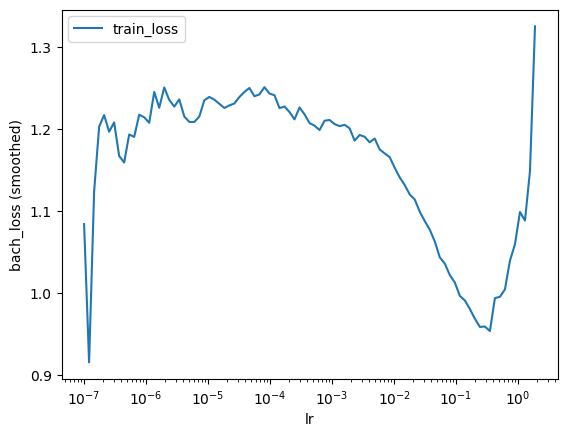

In [16]:
batch_size = 32
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=6)
_ = lr_finder.plot()

In [17]:
lr_finder.get_best_lr()

np.float64(0.0001)

In [18]:
model.optimizer.set_lr(0.0001)

In [19]:
epochs = 150
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 1.2160,	val_loss: 0.8051
1:	[0s / 0s],		train_loss: 1.2017,	val_loss: 0.7948
2:	[0s / 0s],		train_loss: 1.2042,	val_loss: 0.7858
3:	[0s / 0s],		train_loss: 1.1643,	val_loss: 0.7799
4:	[0s / 0s],		train_loss: 1.1482,	val_loss: 0.7690
5:	[0s / 0s],		train_loss: 1.0000,	val_loss: 0.7566
6:	[0s / 0s],		train_loss: 1.1557,	val_loss: 0.7615
7:	[0s / 0s],		train_loss: 1.0361,	val_loss: 0.7534
8:	[0s / 0s],		train_loss: 1.1037,	val_loss: 0.7437
9:	[0s / 0s],		train_loss: 1.0437,	val_loss: 0.7397
10:	[0s / 0s],		train_loss: 1.0509,	val_loss: 0.7380
11:	[0s / 0s],		train_loss: 1.0344,	val_loss: 0.7398
12:	[0s / 0s],		train_loss: 0.9781,	val_loss: 0.7320
13:	[0s / 0s],		train_loss: 1.0141,	val_loss: 0.7191
14:	[0s / 0s],		train_loss: 0.9721,	val_loss: 0.7185
15:	[0s / 0s],		train_loss: 1.0228,	val_loss: 0.7158
16:	[0s / 0s],		train_loss: 0.9516,	val_loss: 0.7067
17:	[0s / 0s],		train_loss: 0.9082,	val_loss: 0.7093
18:	[0s / 0s],		train_loss: 0.9199,	val_loss: 0.7062
19:

/Users/simrantanwar/opt/anaconda3/envs/venv/lib/python3.9/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch

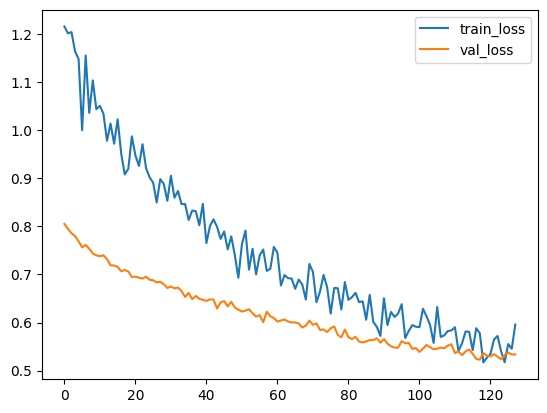

In [20]:
_ = log.plot()

# Prediction 

In [21]:
surv = model.predict_surv_df(x_test)

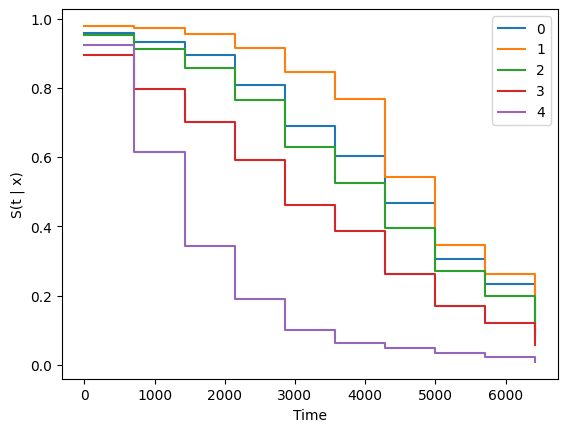

In [22]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [23]:
surv = model.interpolate(10).predict_surv_df(x_test)

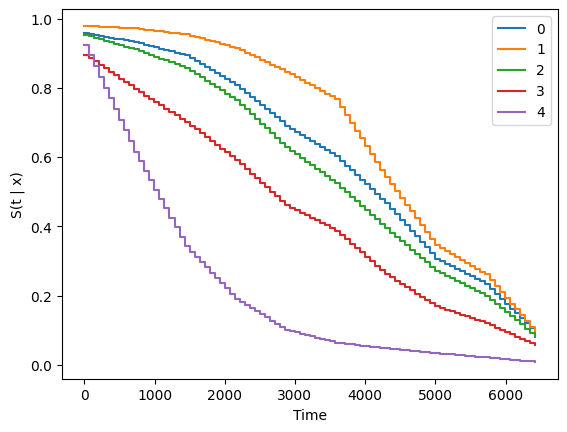

In [24]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

# Evaluation

In [25]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

# Concordance

In [26]:
ev.concordance_td('antolini')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


0.8136449778900822

# beier score

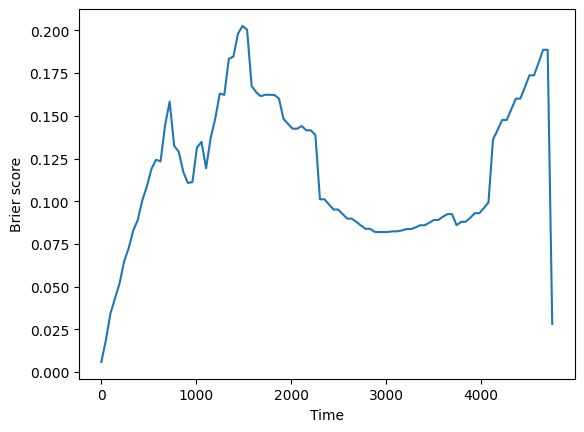

In [27]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

In [28]:
ev.integrated_brier_score(time_grid) 

np.float64(0.11825836397205094)

# Negatvie binominal log likelihood

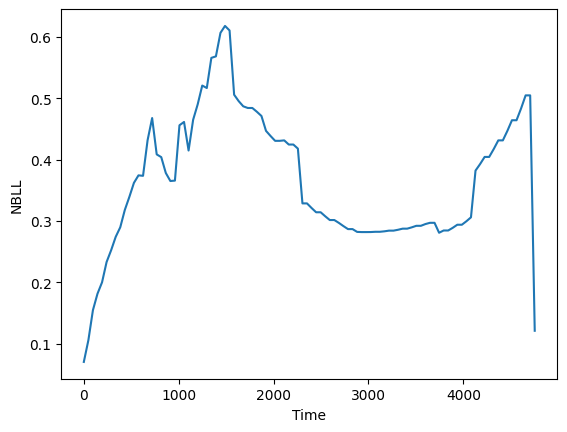

In [29]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [30]:
ev.integrated_nbll(time_grid) 

np.float64(0.36825473757686966)